### Importing libraries

In [4]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

import matplotlib.pyplot as plt

### Reading dataset

In [5]:
dir = '/leapGestRecog'

In [6]:
images = []
labels = []
for directory in os.listdir(dir):
  for subDir in os.listdir(os.path.join(dir,directory)):
    for img in os.listdir(os.path.join(dir, directory, subDir)):
      img_path = os.path.join(dir, directory, subDir, img)
      images.append(img_path)
      labels.append(subDir)

### Converting the data to DataFrame

In [8]:
Iseries = pd.Series(images, name="Images")
Lseries = pd.Series(labels, name="labels")
hand_gesture_data = pd.concat([Iseries, Lseries], axis=1)
hand_gesture_df = pd.DataFrame(hand_gesture_data)

### Splitting the dataset into train and test

In [11]:
X_train, X_test = train_test_split(hand_gesture_df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(hand_gesture_df, test_size=0.3, random_state=42)

### Data Preprocessing

In [12]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="Images",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= X_test,x_col="Images", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="Images", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )


Found 14000 validated image filenames belonging to 10 classes.

Found 4000 validated image filenames belonging to 10 classes.

Found 6000 validated image filenames belonging to 10 classes.


In [13]:
classes=list(train.class_indices.keys())
print (classes)

['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


### Data visualization

In [14]:
def show_hand_gesture(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

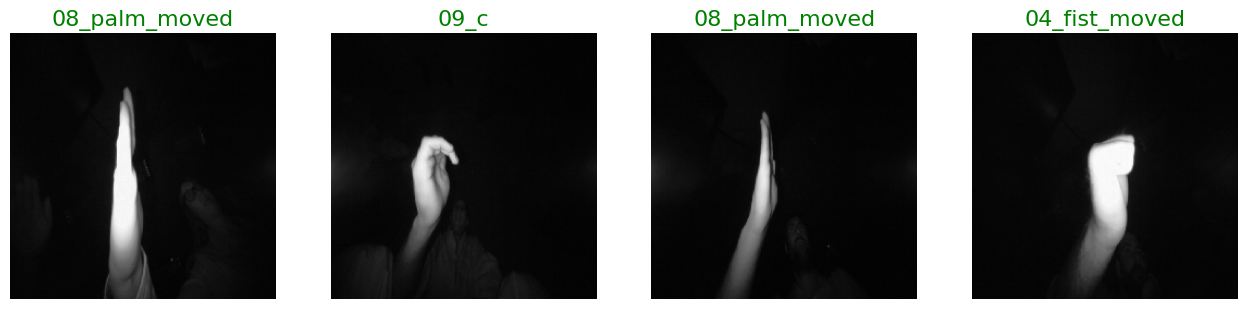

In [15]:
show_hand_gesture(train)

# Building my model

In [20]:
model = Sequential([
    Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3)),

    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    MaxPool2D(pool_size=(2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    MaxPool2D(pool_size=(2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_18 (Conv2D)          (None, 73, 73, 128)       24704     

                                                                 

 batch_normalization_18 (Ba  (None, 73, 73, 128)       512       

 tchNormalization)                                               

                                                                 

 conv2d_19 (Conv2D)          (None, 73, 73, 256)       819456    

                                                                 

 batch_normalization_19 (Ba  (None, 73, 73, 256)       1024      

 tchNormalization)                                               

                                                                 

 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 256)       0         

 g2D)                                                            

                                      

In [21]:
history = model.fit(train, epochs=3, validation_data=val, verbose=1)

Epoch 1/3

3500/3500 [==============================] - 197s 56ms/step - loss: 0.4896 - accuracy: 0.8483 - val_loss: 0.0043 - val_accuracy: 0.9993

Epoch 2/3

3500/3500 [==============================] - 194s 56ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.0011 - val_accuracy: 0.9997

Epoch 3/3

3500/3500 [==============================] - 204s 58ms/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 0.0012 - val_accuracy: 0.9995


In [22]:
model.evaluate(test, verbose=1)

1000/1000 [==============================] - 18s 18ms/step - loss: 0.0013 - accuracy: 0.9995


[0.0013108871644362807, 0.9994999766349792]

In [23]:
model.save("hand_gesture_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


### Results

In [24]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

1000/1000 [==============================] - 20s 20ms/step


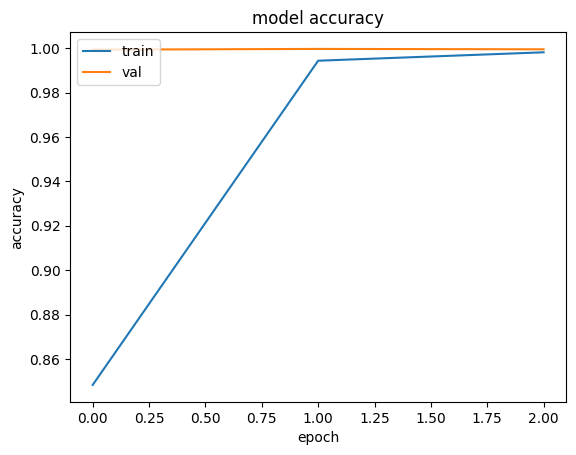

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

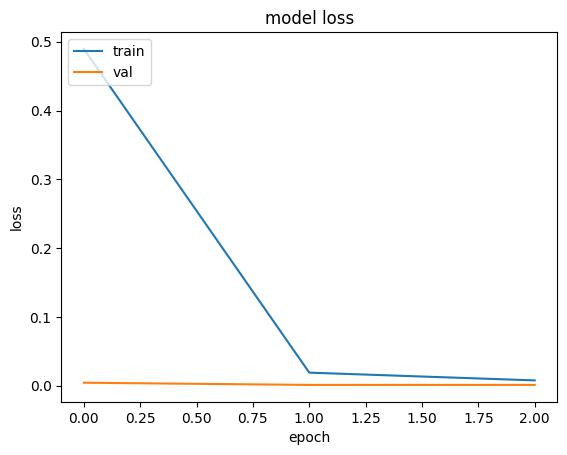

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_test = X_test.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

               precision    recall  f1-score   support



      01_palm       1.00      1.00      1.00       404

         02_l       1.00      1.00      1.00       377

      03_fist       1.00      1.00      1.00       404

04_fist_moved       1.00      1.00      1.00       410

     05_thumb       1.00      1.00      1.00       417

     06_index       1.00      1.00      1.00       366

        07_ok       1.00      1.00      1.00       418

08_palm_moved       1.00      1.00      1.00       403

         09_c       1.00      1.00      1.00       392

      10_down       1.00      1.00      1.00       409



     accuracy                           1.00      4000

    macro avg       1.00      1.00      1.00      4000

 weighted avg       1.00      1.00      1.00      4000



Accuracy of the Model: 100.0%
